# Football Analytics

# TO DO 

- Data discovery
- how many attempts
- how many goals
- on / off target attempts ratio
- goals / attempts ratio to compare
- top attempts players
- top goals players
- 

## Do tall player score more header goals than other players?

I have been a fan of Real Madrid for many years. 
From 2013 to 2017, the "BBC era" (Gareth Bale, Karim Benzema, Cristiano Ronaldo) ruled over Europe, winning 4 Champions League trophies.
One peculiarity of this team was the number of header goals they scored throughout these years.
The team was just so dangerous on set pieces and crosses.
Now, I do remember these players as pretty tall: CR7 is 187 cm, Bale is 186 cm, Benzema is 185 cm.

This got me curious: is there a link between a player's height and its likelihood to score a goal?

With this notebook, I will try to answer this question.

I will explore the following data analysis notions:
- correlation
- selection bias
- p-value

I will use 3 datasets for this:
- players
- goals scored
- goal attempts (shots on + shots off)

## Imports

In [1]:
# processing
import pandas as pd
import numpy as np
from scipy.stats import norm, percentileofscore

# visualizations
from matplotlib import pyplot as plt
import seaborn as sns

## Step 1 - Data preparation

In [2]:
goals_filepath = r"C:\Users\Pierre et Sophie\Documents\GitHub\football_analytics\outputs\Goal events.csv"
shots_filepath = r"C:\Users\Pierre et Sophie\Documents\GitHub\football_analytics\outputs\Shot events.csv"
players_filepath = r"C:\Users\Pierre et Sophie\Documents\GitHub\football_analytics\outputs\Players information.csv"

goals_df = pd.read_csv(goals_filepath)
shots_df = pd.read_csv(shots_filepath)
players_df = pd.read_csv(players_filepath)

### Players

In [3]:
# rounding size to upper unit
players_df["player_height"] = np.round(players_df["player_height"], 0).astype("int64")
players_df = players_df.rename(columns={"player_api_id": "player"})

### All headers (attempts + goals) + player's data

In [4]:
# attempts
temp_df1 = shots_df.copy()
temp_df1 = temp_df1.loc[temp_df1["event_sub_type"].isin(["header", "big chance header", "blocked_header"])]
temp_df1 = temp_df1[["event_id", "event_type", "event_sub_type", "shot_by"]]
temp_df1["type"] = temp_df1["event_type"]
temp_df1 = temp_df1.rename(columns={"shot_by": "player", "event_type": "sub_type"})

# goals
temp_df2 = goals_df.copy()
temp_df2 = temp_df2.loc[temp_df2["event_sub_type"] == "header"]
temp_df2 = temp_df2[["event_id", "event_type", "event_sub_type", "scored_by"]]
temp_df2["type"] = "shoton"
temp_df2 = temp_df2.rename(columns={"scored_by": "player", "event_type": "sub_type"})

# concatenation
header_attempts_and_goals_df = pd.concat([temp_df1, temp_df2])

# fetching player's details
header_attempts_and_goals_df["player"].fillna(0).astype('int64')
header_attempts_and_goals_df = header_attempts_and_goals_df.merge(
    right=players_df,
    on="player",
    how="left"
)

# more cleaning
cols = ["player", "player_height", "player_weight"]
for col in cols:
    header_attempts_and_goals_df[col] = header_attempts_and_goals_df[col].fillna(0).astype('int64')

## Step 2 - Data discovery

On players:
- What is football player's height distribution?
- What is a tall player? Are CR7, GB11, KB9 considered tall players? (in which percentile do they fall)

On goals:
- How many scored goals will we analyze?
- How many of these are header goals?

### A - How tall are European Football players?

The below chart indicates the median to be 183 cm. 
<br>In other words, half of all players are shorter than 183 cm, the other half are taller than 183 cm.
<br>The 95% confidence interval means 95% of all football players are within a defined range, of 170cm to approx. 193 cm.

In [5]:
# data prep

players_height_sorted = pd.Series(players_df["player_height"])
players_height_sorted = np.sort(players_height_sorted)

players_height_mean = np.mean(players_height_sorted)
players_height_std_dev = np.std(players_height_sorted)

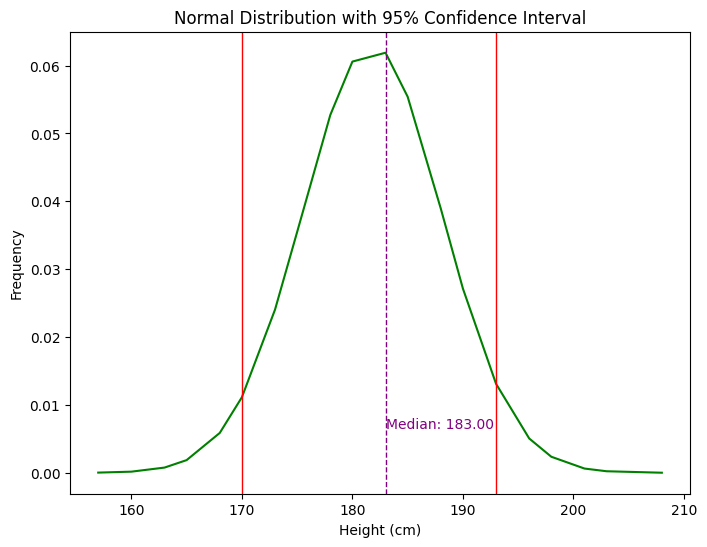

In [6]:
# plotting

plt.figure(figsize=(8, 6))

plt.plot(
    players_height_sorted, 
    norm.pdf(players_height_sorted, players_height_mean, players_height_std_dev), 
    color="green", 
    label="KDE",
    fillstyle="none"
)

# plotting values for labels
players_height_q2 = np.percentile(players_height_sorted, 50)

# drawing 95% confidence interval
percentiles = np.percentile(players_height_sorted, [2.5, 97.5])
for percentile in percentiles:
    plt.axvline(percentile, color="red", linestyle="-", linewidth=1)

# median line and label
plt.axvline(players_height_q2, color='purple', linestyle='--', linewidth=1)
plt.text(players_height_q2, plt.ylim()[1]*0.1,color='purple', s=f"Median: {players_height_q2:.2f}")

# chart labels and axis
plt.title('Normal Distribution with 95% Confidence Interval')
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

### B - Are BBC players considered tall?

<br> Benzema is at median level, so he is taller than 50% of all the european players.
<br> Bale is at taller than 70% of all european players.
<br> Ronaldo is at taller than 76% of all european players.

All three players are on the taller end of the european footballer spectrum.
<br>That being said, player's size doesn't vary much and the difference with most players, in cm, is not very significant.
<br>Only 2 centimeters separate Q2 from Q3.

In [7]:
# percentile for each of the BBC players

players_dict = {
    "Benzema": 183,
    "Bale": 185,
    "Ronaldo": 187
}

for key, value in players_dict.items():
    player_rank = percentileofscore(players_height_sorted, value, kind="mean")
    print(f"{key} ranks in the {player_rank:.0f}th percentile")

Benzema ranks in the 56th percentile
Bale ranks in the 70th percentile
Ronaldo ranks in the 76th percentile


### C - How many attempts and goals are we analyzing?

We are analyzing over 30k attempts, with 10k on target and 4k goals.

There are different kind of goals. While we care about headers, let's have a quick overview of all goals.
<br>Always have an eye on the quality of your data. Here, I can spot (in red), a few anomalies.
<br>Unfortunately, I do not have any documentation related to my data set to explain these so I will only disregard these.

Lots of header goals scored. 1550 for our analysis. This should be enough for significant findings.

In [8]:
# data prep

agg_header_attempts_goals_df = header_attempts_and_goals_df.groupby(by="sub_type").agg({"event_id": "count"}).reset_index()
agg_header_attempts_goals_df = agg_header_attempts_goals_df.sort_values(by="event_id", ascending=False)

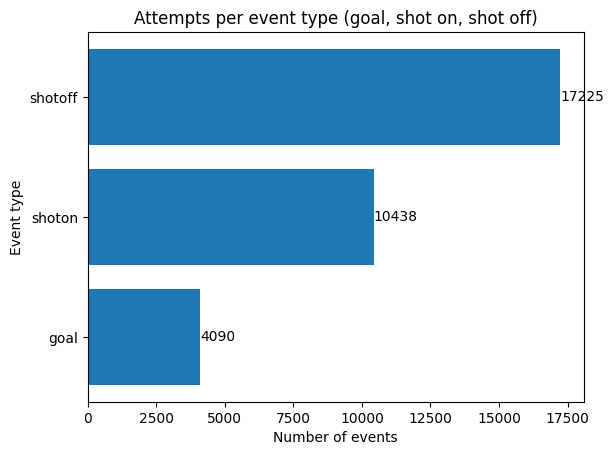

In [9]:
# plotting

fig, ax = plt.subplots()
categories = agg_header_attempts_goals_df["sub_type"]
values = agg_header_attempts_goals_df["event_id"]
bars = ax.barh(categories, values)

# labels and title
for bar, value in zip(bars, values):
    ax.text(value, bar.get_y() + bar.get_height() / 2, str(value),
            va='center', ha='left', color='black')

ax.set_xlabel("Number of events")
ax.set_ylabel("Event type")
ax.set_title("Attempts per event type (goal, shot on, shot off)")

# descending order
ax.invert_yaxis()

plt.show()

### D - Which players stand out?

Some players stand out among all of them.
<br>Let's have a look at the players who attempt the most, then who score the most, then let's analyze the two together.
<br>Most of the top header goal scorers are also among the players who attempt the most (highlighted in red).

<br>To rank players based on both attempts and goals, we will apply a weighted ranking. Goals will account for 75% of the rank, attempts for 25%.

In [49]:
# data prep

# attempts per player
attempts_per_player = header_attempts_and_goals_df.groupby(by="player_name", as_index=False).agg({"event_id": "count"})
attempts_per_player = attempts_per_player.sort_values(by="event_id", ascending=False)
attempts_per_top_ten_player = attempts_per_player.head(10)

# goals per player
goals_per_player = header_attempts_and_goals_df.loc[header_attempts_and_goals_df["sub_type"] == "goal"]
goals_per_player = goals_per_player.groupby(by="player_name", as_index=False).agg({"event_id": "count"})
goals_per_player = goals_per_player.sort_values(by="event_id", ascending=False)
goals_per_top_ten_player = goals_per_player.head(10)

# players in both top 10s
top_10_header_attempters = attempts_per_top_ten_player["player_name"].to_list()
top_10_header_scorers = goals_per_top_ten_player["player_name"].to_list()
players_in_both_tops = [item for item in top_10_header_attempters if item in top_10_header_scorers]

In [50]:
players_in_both_tops

['Peter Crouch',
 'Andy Carroll',
 'Fernando Llorente',
 'Cristiano Ronaldo',
 'Edin Dzeko',
 'Olivier Giroud',
 'Steven Fletcher']

In [51]:
# styling

players_in_both_top_colors = 'green'
default_color = 'blue'
colors1 = [players_in_both_top_colors if category in players_in_both_tops else default_color for category in attempts_per_player["player_name"]]
colors2 = [players_in_both_top_colors if category in players_in_both_tops else default_color for category in goals_per_player["player_name"]]

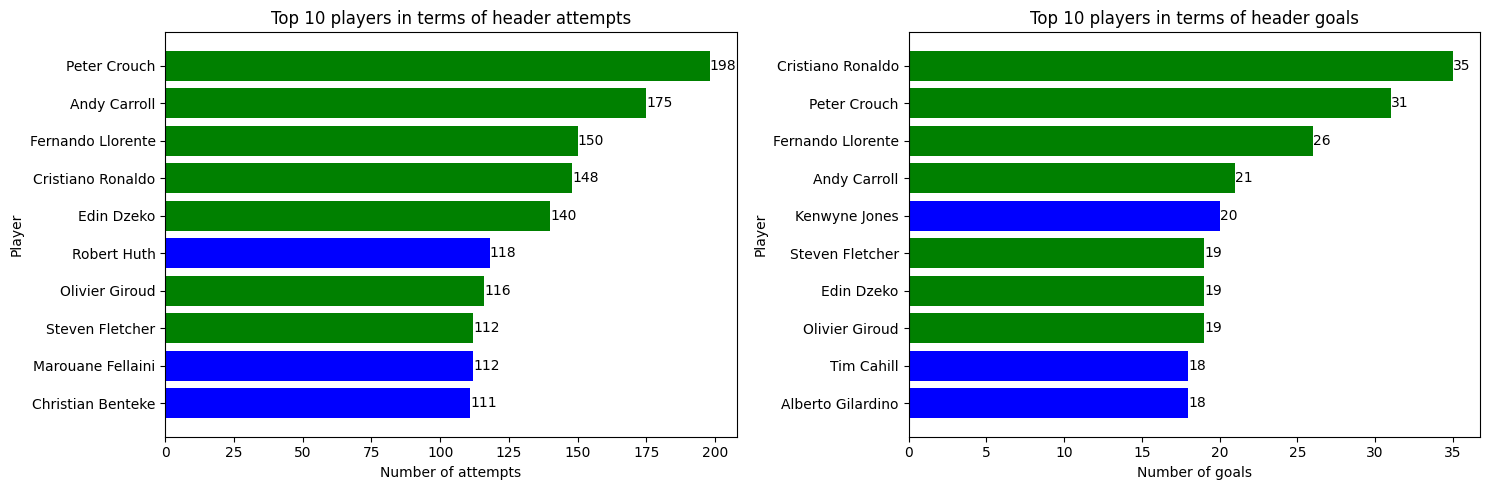

In [52]:
# plotting

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

categories = attempts_per_top_ten_player["player_name"]
values = attempts_per_top_ten_player["event_id"]
bars = axes[0].barh(categories, values, color=colors1)

# labels and title
for bar, value in zip(bars, values):
    axes[0].text(value, bar.get_y() + bar.get_height() / 2, str(value),
            va='center', ha='left', color='black')

axes[0].set_xlabel("Number of attempts")
axes[0].set_ylabel("Player")
axes[0].set_title("Top 10 players in terms of header attempts")

# descending order
axes[0].invert_yaxis()

categories = goals_per_top_ten_player["player_name"]
values = goals_per_top_ten_player["event_id"]
bars = axes[1].barh(categories, values, color=colors2)

# labels and title
for bar, value in zip(bars, values):
    axes[1].text(value, bar.get_y() + bar.get_height() / 2, str(value),
            va='center', ha='left', color='black')

axes[1].set_xlabel("Number of goals")
axes[1].set_ylabel("Player")
axes[1].set_title("Top 10 players in terms of header goals")

# descending order
axes[1].invert_yaxis()

# adjusts padding between / around subplots
plt.tight_layout()

In [54]:
# data prep

attempts_goals_per_player = pd.merge(goals_per_player, attempts_per_player, on="player_name", how="left")
attempts_goals_per_player = attempts_goals_per_player.rename(columns={"event_id_x": "goals", "event_id_y": "attempts"})
attempts_goals_per_player["attempts"] = attempts_goals_per_player["attempts"].fillna(0).astype("int64")
attempts_goals_per_player["goals"] = attempts_goals_per_player["goals"].fillna(0).astype("int64")
attempts_goals_per_player["weighted_score"] = (0.75 * attempts_goals_per_player["goals"]) + (0.25 * attempts_goals_per_player["attempts"])
attempts_goals_per_player = attempts_goals_per_player.sort_values(by="weighted_score", ascending=False)

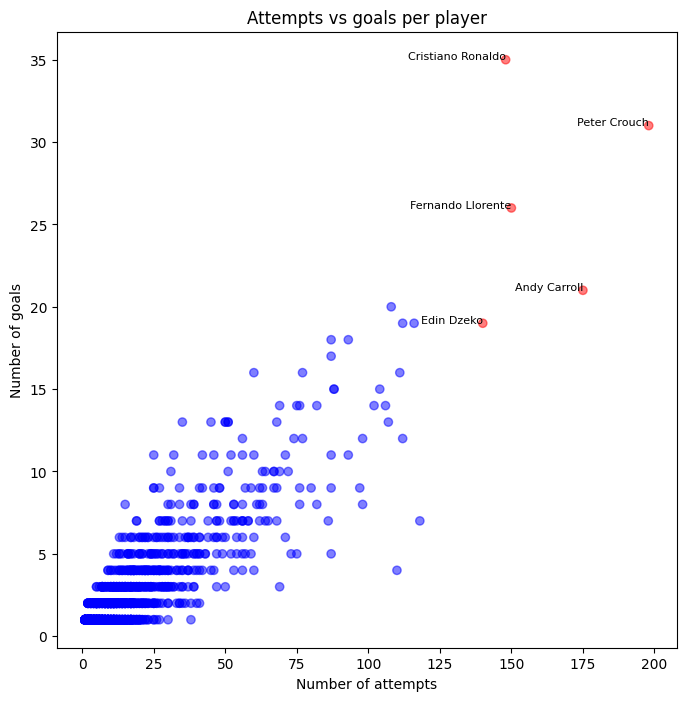

In [55]:
# plotting

fig, ax = plt.subplots(figsize=(8, 8))

top_10_header_attempts_goals_players = attempts_goals_per_player["player_name"].head(5).unique()
colors3 = ["red" if player in top_10_header_attempts_goals_players else "blue" for player in attempts_goals_per_player["player_name"]]

for row, data in enumerate(attempts_goals_per_player.iterrows(), start=0):
    if attempts_goals_per_player["player_name"][row] in top_10_header_attempts_goals_players:
        plt.text(attempts_goals_per_player["attempts"][row], attempts_goals_per_player["goals"][row], attempts_goals_per_player["player_name"][row], fontsize=8, ha='right')

plt.scatter(attempts_goals_per_player["attempts"], attempts_goals_per_player["goals"], alpha=0.5, c=colors3)

ax.set_xlabel("Number of attempts")
ax.set_ylabel("Number of goals")
ax.set_title("Attempts vs goals per player")

plt.show()

In [ ]:
all_header_goals_df = header_attempts_and_goals_df.copy()
# all_header_goals_df = all_header_goals_df.loc[all_header_goals_df["sub_type"] == "goal"]

In [ ]:
# all_header_goals_df.loc[all_header_goals_df["player_name"] == "Peter Crouch"]

In [ ]:
tata = all_header_goals_df.groupby(by="player", as_index=False).agg(
    goals=("sub_type", lambda x: (x == "goal").sum()),
    attempts=("sub_type", lambda x: (x.isin(["shoton", "shotoff"])).count())
)

tata.loc[tata["player"] == 30830]

In [ ]:
all_header_goals_df

In [ ]:
testdf = all_header_goals_df.groupby(by="player", as_index=False).agg({"event_id": "nunique", "player_height": "first"})
testdf = testdf.loc[testdf["player_height"] != 0]

In [ ]:
testdf2 = testdf.groupby(by="player_height", as_index=False).agg({"event_id": "sum", "player": "nunique"})

In [ ]:
plt.scatter(testdf["player_height"], testdf["event_id"], alpha=0.5)

In [ ]:
s1 = testdf2["player"]
s2 = testdf2["event_id"]

s1.corr(s2)

In [ ]:
testdf2

In [ ]:
# from sklearn.cluster import KMeans

# # Clustering (k-means)
# kmeans = KMeans(n_clusters=3)

# attempts_per_player['cluster_group'] = kmeans.fit_predict(attempts_per_player[['event_id']])

In [ ]:
# attempts_per_player["cluster_group"].value_counts()

In [ ]:
# goals_per_type = header_attempts_and_goals_df.groupby(by="event_sub_type").agg({"event_id": "count"}).reset_index()
# goals_per_type = goals_per_type.sort_values(by="event_id", ascending=True)

In [ ]:
# # aggregation per goal type + sort values in descending order
# goals_per_type = goal_types_per_player.groupby(by="event_sub_type").agg({"event_id": "count"}).reset_index()
# goals_per_type = goals_per_type.sort_values(by="event_id", ascending=True)

In [ ]:
# # flagging DQ issues with another color
# data_quality_issues = ["saved_back_into_play", "saved", "missed", "post"]
# dq_issues_color = 'red'
# default_color = 'blue'
# colors = [dq_issues_color if category in data_quality_issues else default_color for category in goals_per_type["event_sub_type"]]

# # plotting
# fig, ax = plt.subplots()
# categories = goals_per_type["event_sub_type"]
# values = goals_per_type["event_id"]
# bars = ax.barh(goals_per_type["event_sub_type"], goals_per_type["event_id"], color=colors)

# # labels and title
# for bar, value in zip(bars, values):
#     ax.text(value, bar.get_y() + bar.get_height() / 2, str(value),
#             va='center', ha='left', color='black')

# ax.set_xlabel("Number of goals")
# ax.set_ylabel("Goal type")
# ax.set_title("Number of goals per goal type")

# plt.show()

## D - How many header attempts (on and off target) are we analyzing?

We are analyzing over 27k header attempts. 28.5k if we add the header goals scored.

For 3 header attempts, 2 are off target and 1 is on target.

In [ ]:
# filtering on headers
header_type = ["header", "big chance header", "blocked_header"]

header_attempts_df = shots_df.copy()
header_attempts_df = header_attempts_df.loc[header_attempts_df["event_sub_type"].isin(header_type)]
header_attempts_df = header_attempts_df.groupby(by="event_type", as_index=False).agg({"event_id":"count"})

In [ ]:
# plotting all shots
header_shots_data = pd.Series(header_attempts_df["event_id"])
header_shots_labels = pd.Series(header_attempts_df["event_type"])

plt.pie(header_shots_data, labels=header_shots_labels, autopct="%1.1f%%")
plt.legend(loc="upper right")
plt.show()

## Step 3 - Relationship between tall players and header goals

### A - Overview of goals per player's height

Looking at the below chart, we notice the number of goals per player's height.
<br>There seems to be some kind of relationship between tall players and header goals. Lots of these goals are scored by players over approx. 185 cm.

In [ ]:
# filtering on header goals
headers_and_player_height = goal_types_per_player.loc[goal_types_per_player["event_sub_type"] == "header"]

plt.scatter(headers_and_player_height["player_height"], headers_and_player_height["event_id"], alpha=0.5)

# median player's height for reference
players_height_q2 = np.percentile(players_height_sorted, 50)
plt.axvline(players_height_q2, color='purple', linestyle='--', linewidth=1, label=f"Q2: {players_height_q2:.2f}")
plt.text(players_height_q2, plt.ylim()[1]*0.9,color='purple', s=f"Median: {players_height_q2:.2f}")

# adding labels
plt.title('Number of header goals scored per player\'s height')
plt.xlabel('Height (cm)')
plt.ylabel('Number of goals')
plt.show()

### B - Correlation between a player's height and header goals

Beware of selection bias: 
- extremely tall players (e.g. over 2m) are rare, so it is not abnormal to find few goals scored by very tall players
- the question is rather: for a given height, in cm, how many players are there and how many goals are scored
- correlation should be computed accordingly

In [ ]:
shots_df.dtypes

In [ ]:
all_headers = shots_df.copy()

# filling NA values with a 0 and making it int type
all_headers["shot_by"] = all_headers["shot_by"].fillna(0).astype('int64')

all_headers = all_headers.loc[all_headers["event_sub_type"] == "header"]

# aggregation at goal type and scorer levels
all_headers_per_player = all_headers.groupby(
        by=["event_sub_type", "shot_by"], 
        as_index=False,
        dropna=False
    )["event_id"].nunique().sort_values(by="event_id", ascending=False)

all_headers_per_player = all_headers_per_player.merge(
    right=all_players_df,
    left_on="shot_by",
    right_on="player_api_id",
    how="left"
)

all_headers_per_player = all_headers_per_player.dropna()


In [ ]:
headers_and_player_height = headers_and_player_height.loc[
    (~headers_and_player_height["player_height"].isna())
    ]

headers_and_player_height["player_height"] = np.round(headers_and_player_height["player_height"]).astype(int)

headers_and_player_height = headers_and_player_height[["event_id", "player_height"]]

headers_and_player_height["event_id"].sum()

In [ ]:
# copy of goal_df
header_goals = goal_df.loc[
    goal_df["event_sub_type"] == "header"
    ]

header_goals["scored_by"] = header_goals["scored_by"].fillna(0).astype('int64')

header_goals = header_goals.merge(
    right=all_players_df,dd
    left_on="scored_by",
    right_on="player_api_id",
    how="left"
)

header_goals = header_goals.loc[
    ~header_goals["player_height"].isna()
    ]

header_goals["player_height"] = header_goals["player_height"].astype(int)

In [ ]:
# copy of goal_df
header_goals = goal_df.loc[
    goal_df["event_sub_type"] == "header"
    ]

header_goals["scored_by"] = header_goals["scored_by"].fillna(0).astype('int64')

header_goals = header_goals.merge(
    right=all_players_df,
    left_on="scored_by",
    right_on="player_api_id",
    how="left"
)

header_goals = header_goals.loc[
    ~header_goals["player_height"].isna()
    ]

header_goals["player_height"] = header_goals["player_height"].astype(int)

In [ ]:
header_goals = header_goals.groupby(by="player_height", as_index=False)["event_id"].nunique().sort_values(by="player_height", ascending=True)

In [ ]:
s1 = players_and_goals_by_height["player_height"]
s2 = players_and_goals_by_height["event_id"]

s1.corr(s2)

In [ ]:
correlation_df = players_by_height.merge(
    right=header_goals,
    on="player_height",
    how="left"
)

In [ ]:
s1 = correlation_df["player_api_id"]
s2 = correlation_df["event_id"]

s1.corr(s2)